# General Analysis Notebook
This notebook intents to tackle the problem of analyzing a whole batch. It mainly iterates over the many directories and process each one. Then makes a graph indicating the resulting value and the expected one. This is a neat way to understand how well is the analyzer performing generally.

## Requirements
This notebook requires that the root directory where reports are contains a ```description.yml``` file, indicating the various properties of the batch. Including the connection's top speed, the throttling configuration, the start time for each change and the time lapse for each throttling speed.

In [8]:
# Setup and import everything
%matplotlib notebook

import pandas as pd
import yaml

from os import getcwd, listdir
from os.path import join, isdir

from processor import analysis, reports

from IPython.display import display

base_directory = join(getcwd(), 'batch-test-reports')
with open(join(base_directory, 'description.yml')) as fp:
    batch_description = yaml.load(fp)
batch_description

{'connection_speed': 1500,
 'experiment': [{'lapse': 2520, 'speed': 1500, 'start': 1505082300},
  {'lapse': 1980, 'speed': 1125, 'start': 1505084820},
  {'lapse': 1380, 'speed': 750, 'start': 1505086800},
  {'lapse': 1860, 'speed': 375, 'start': 1505088780}]}

In [9]:
def get_analyzer_results(reports_batch_dir):
    rh = reports.ReportHandler(join(base_directory, reports_batch_dir))
    ip, obs_set = rh.get_ip_and_processable_observations()
    if ip is None and obs_set is None:
        raise ValueError('Reports batch directory {} has no reports to use!'.format(reports_batch_dir))
    analyzer = analysis.Analyzer(obs_set)
    results = analyzer.get_results()
    return results

def get_expected_usage(batch_start_time, batch_end_time):
    batch_starting_conf, batch_ending_conf = None, None
    for experiment_configuration in batch_description['experiment']:
        start = experiment_configuration['start']
        lapse = experiment_configuration['lapse']
        if start <= batch_start_time < start + lapse:
            batch_starting_conf = experiment_configuration
        if start <= batch_end_time < start + lapse:
            batch_ending_conf = experiment_configuration
        if batch_starting_conf is not None and batch_ending_conf is not None:
            break
    if batch_starting_conf is None and batch_ending_conf is None:
        raise ValueError('Batch for start time: {} and end time {} has no config.'.format(batch_start_time,
                                                                                          batch_end_time))
    if batch_ending_conf is None:
        expected_usage = batch_starting_conf['speed'] / batch_description['connection_speed']
    elif batch_starting_conf is None:
        expected_usage = batch_ending_conf['speed'] / batch_description['connection_speed']
    elif batch_starting_conf['speed'] == batch_ending_conf['speed']:
        expected_usage = batch_starting_conf['speed'] / batch_description['connection_speed']
    else:
        batch_lapse = batch_end_time - batch_start_time
        batch_starting_conf_lapse = batch_starting_conf['start'] + batch_starting_conf['lapse'] - batch_start_time
        batch_ending_conf_lapse = batch_end_time - batch_ending_conf['start']
        expected_usage = ((batch_starting_conf_lapse / batch_lapse) * batch_starting_conf['speed'] +
            (batch_ending_conf_lapse / batch_lapse) * batch_ending_conf['speed']) / batch_description['connection_speed']
        print(batch_start_time, batch_end_time, 
              batch_lapse, batch_starting_conf_lapse, batch_ending_conf_lapse, 
              batch_starting_conf['speed'], batch_ending_conf['speed'],
              expected_usage)
    return expected_usage
    

In [12]:
columns = ['batch_start_time', 'batch_end_time', 
           'downstream_hurst_rs', 'downstream_hurst_wavelet',
           'downstream_quality', 'downstream_usage',
           'upstream_hurst_rs', 'upstream_hurst_wavelet',
           'upstream_quality', 'upstream_usage',
           'expected_downstream_usage']
data = pd.DataFrame(columns=columns)

for reports_batch_dir in listdir(base_directory):
    reports_batch_dir_path = join(base_directory, reports_batch_dir)
    if not isdir(reports_batch_dir_path): continue
    results = get_analyzer_results(reports_batch_dir_path)
    batch_start_time = int(reports_batch_dir)
    batch_end_time = results['timestamp']
    expected_usage = get_expected_usage(batch_start_time, batch_end_time)
    df_ = pd.DataFrame([(batch_start_time, batch_end_time, 
                         results['downstream']['hurst']['rs'], results['downstream']['hurst']['wavelet'],
                         results['downstream']['quality'], results['downstream']['usage'], 
                         results['upstream']['hurst']['rs'], results['upstream']['hurst']['wavelet'],
                         results['upstream']['quality'], results['upstream']['usage'],
                         expected_usage)
                       ], 
                       columns=columns)
    data = data.append(df_)
data = data.sort_values(by=['batch_start_time']).reset_index(drop=True)
display(data)

1505083975 1505085134 1159 845 314 1500 1125 0.9322691975841243
1505084539 1505085397 858 281 577 1500 1125 0.831876456876457
1505086751 1505087941 1190 49 1141 1125 750 0.5102941176470589
1505086200 1505087214 1014 600 414 1125 750 0.6479289940828403


,batch_start_time,batch_end_time,downstream_hurst_rs,downstream_hurst_wavelet,downstream_quality,downstream_usage,upstream_hurst_rs,upstream_hurst_wavelet,upstream_quality,upstream_usage,expected_downstream_usage
0,1505081735,1505082387,0.558375,0.480406,1.0,0.179396,0.510699,0.260455,1.0,0.786856,1.000000
1,1505082284,1505083470,0.480963,0.516774,1.0,0.212500,0.550842,0.431526,1.0,0.791071,1.000000
2,1505082850,1505083992,0.511368,0.485956,1.0,0.125220,0.502497,0.422851,1.0,0.913580,1.000000
3,1505083412,1505084062,0.575853,0.412303,1.0,0.103571,0.513219,0.471568,1.0,0.958929,1.000000
4,1505083975,1505085134,0.579314,0.557478,1.0,0.752182,0.560589,0.383408,1.0,0.785340,0.932269
5,1505084539,1505085397,0.497984,0.218229,1.0,0.540404,0.512820,0.469913,1.0,0.843434,0.831876
6,1505085102,1505086101,0.505749,0.513674,1.0,0.439394,0.475671,0.503604,1.0,0.621212,0.750000
7,1505085652,1505086633,0.534933,0.380027,1.0,0.454237,0.585255,0.586199,1.0,0.674576,0.750000
8,1505086200,1505087214,0.478190,0.588307,1.0,0.510204,0.507650,0.470750,1.0,0.739796,0.647929
9,1505086751,1505087941,0.606015,0.539943,1.0,0.990000,0.612618,0.539957,1.0,0.944000,0.510294


<IPython.core.display.Javascript object>


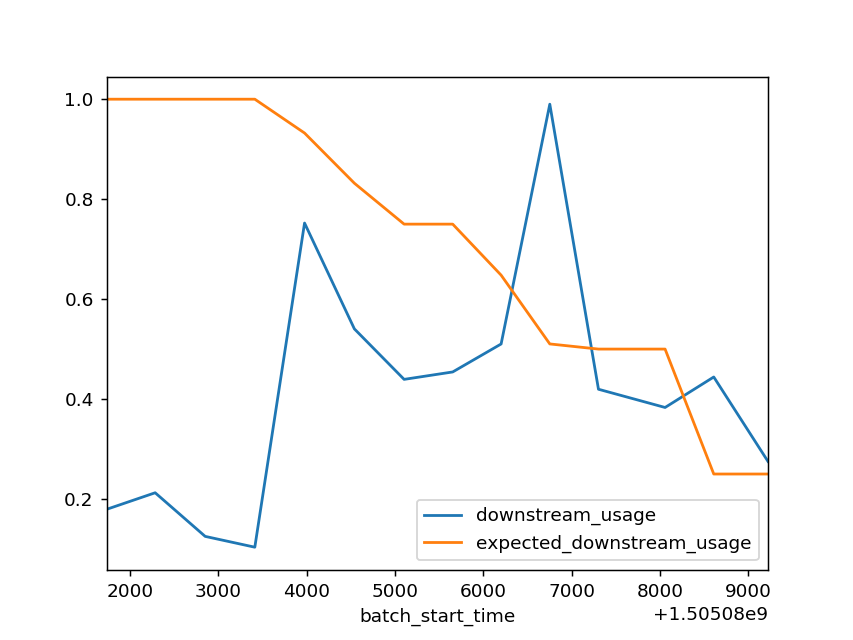

In [13]:
data.plot(x='batch_start_time', y=['downstream_usage', 'expected_downstream_usage'], kind='line')